# Import Libraries

The below block imports all needed libraries. Feel free to add additional libraries that you need and rerun below block.

Two last lines inform you of the Pytorch version and the availability of GPU.
The last line should print `GPU availability: True`.

In [53]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image

print('Pytorch version: ', torch.__version__)
print('GPU availability: ', torch.cuda.is_available())

Pytorch version:  2.5.1+cu121
GPU availability:  False


# Download Dataset
If you are familiar with Linux bash scripts, you can put `!` at the beginning of a command to order Colab of interpreting it as bash scripts instead of python scripts.

The below block downloads MNIST dataset and decompresses it.

In [54]:
!wget https://github.com/myleott/mnist_png/raw/master/mnist_png.tar.gz
!tar xzf mnist_png.tar.gz

--2024-11-22 21:56:01--  https://github.com/myleott/mnist_png/raw/master/mnist_png.tar.gz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/myleott/mnist_png/master/mnist_png.tar.gz [following]
--2024-11-22 21:56:01--  https://raw.githubusercontent.com/myleott/mnist_png/master/mnist_png.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15683414 (15M) [application/octet-stream]
Saving to: ‘mnist_png.tar.gz.2’

mnist_png.tar.gz.2  100%[===================>]  14.96M  --.-KB/s    in 0.1s    

2024-11-22 21:56:01 (117 MB/s) - ‘mnist_png.tar.gz.2’ saved [15683414/15683414]



# Define Dataset Class

In order to use a dataset, we need to design a pytorch Dataset Class to process it.
In the block below, you are required to complete:

* TODO1.1: `def __init__(root, transform)` function to build the MNIST dataset from images included in the `root` directory. Please add code below `TODO1` to complete this function. The dataset should be captured by two lists, i.e., `self.images` that contains all images of MNIST, and `self.labels` that contains the corresponding label of each image in `self.images`.
* TODO1.2: `def __getitem__(index)` to draw a sample at `index` and its corresponding label. This function should return a tuple (X, y), where X is the image (numpy ndarray of shape 1x28x28) and y is a scalar from 0 to 9 representing X's label.

In [55]:
class MNISTDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = []
        self.labels = []
        for label in range(10):
            label_dir = os.path.join(self.root, str(label))
            if not os.path.exists(label_dir):
                continue
            for filename in os.listdir(label_dir):
                filepath = os.path.join(label_dir, filename)
                image = Image.open(filepath).convert('L')
                image_np = np.array(image, dtype=np.uint8).reshape(1, 28, 28)
                self.images.append(image_np)
                self.labels.append(label)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        image_2d = image.reshape(28, 28)
        image_pil = Image.fromarray(image_2d, mode='L')
        if self.transform:
            image_transformed = self.transform(image_pil)
        else:
            image_transformed = torch.from_numpy(image).float()
        return image_transformed, label

    def show_random(self):
        indices = np.random.randint(0, len(self), [16, ])
        f, ax = plt.subplots(4, 4, figsize=(10, 10))
        for i in range(4):
            for j in range(4):
                ax[i, j].imshow(self.images[indices[i * 4 + j]].reshape(28, 28), cmap='gray')
                ax[i, j].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
                ax[i, j].set_title(f'Label: {self.labels[indices[i * 4 + j]]}')
        plt.show()


# Define Model Class

Below is the source code to define neural networks that we will use for training.
A pytorch model necessarily have two functions, i.e., `__init__`, which defines all layers of the network, and `forward`, which receives the input data and processes through all layers defined in `__init__`.

TODO2: Finish the functions below as instructed to complete this Convolutional network.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PytorchConvNet(nn.Module):
    def __init__(self):
        super(PytorchConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc = nn.Linear(in_features=16 * 24 * 24, out_features=10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def name(self):
        return "PytorchConvNet Convolutional Neural Network"


# Create MNISTDataset objects and dataloaders
Below, we create the objects to process training and testing sets of MNIST data.
As there are no held-out validation set, we manually split the training set into training and validation subsets with the ratio of 8:2.

After creating dataset objects, we wrap them by a Pytorch Dataloader to allow several necessary features in training deep learning models, e.g., mini-batch feeding, shuffling.

***Note***: if you successfully complete `__init__` function of `MNISTDataset`, its `show_random` function would successfully randomly show 16 images and corresponding labels in the dataset.

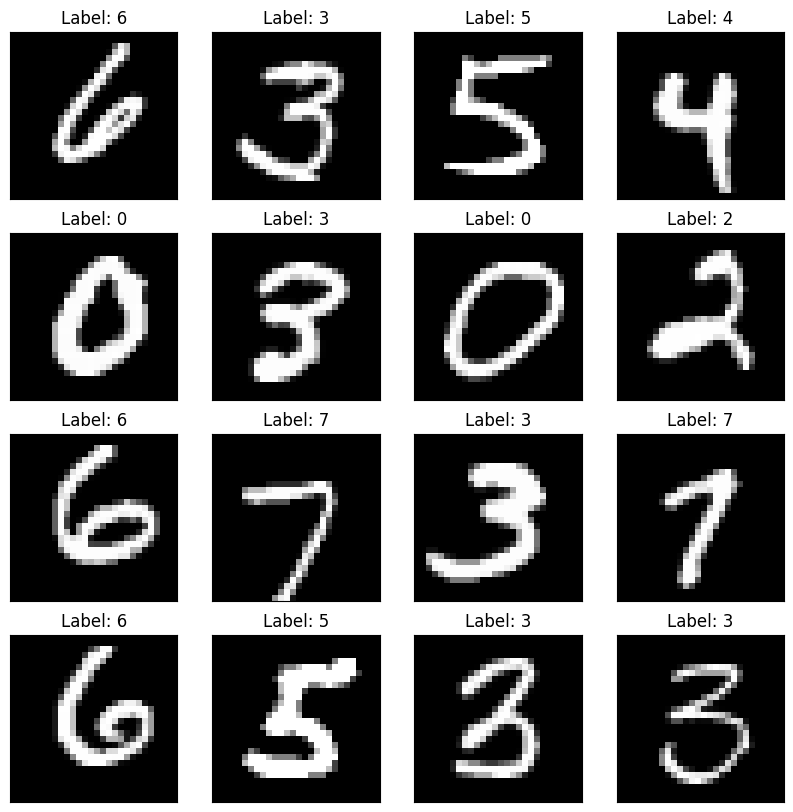

Training set size:  48000
Validation set size:  12000
Testing set size:  10000


In [ ]:
################################################################
# Hyper parameters
################################################################
BATCH_SIZE = 128
# Update the transform to convert grayscale images to 3 channels
transform = transforms.Compose([
    transforms.Pad(padding=2),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))
])

################################################################
# Create training and testing dataset and show random examples
################################################################
trainval_set = MNISTDataset('mnist_png/training', transform=transform)
trainval_set.show_random()

test_set = MNISTDataset('mnist_png/testing', transform=transform)

################################################################
# As there is no validation set
# We split training dataset into training and validation sets
################################################################
train_size = int(0.8 * len(trainval_set))
val_size = len(trainval_set) - train_size
train_set, val_set = torch.utils.data.random_split(
    dataset=trainval_set,
    lengths=[train_size, val_size],
    generator=torch.Generator().manual_seed(42))

################################################################
# Print lengths of subsets
################################################################
print('Training set size: ', len(train_set))
print('Validation set size: ', len(val_set))
print('Testing set size: ', len(test_set))

################################################################
# Print lengths of subsets
################################################################
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=BATCH_SIZE,
    shuffle=False)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=BATCH_SIZE,
    shuffle=False)

# Create Model and Training Process

In the below block, we create an object (our model) from the MLPNet deep neural network defined above.

Then, we create the `criterion` that will compute a loss value from predictions genereated by our model and groundtruth labels. We also create the `optimizer`, which updates our model's learnable parameters based on the loss value to improve its performance.

Finally, we start training the model through `EPOCHS` number of epochs. At each epoch, after training the model through the training subset, we evaluate its loss and accuracy on validation subset. Usually, we would base on the loss or accuracy on validation subset to pick out the best performed model during our training process.

Your tasks:


*   TODO 3: Based on average accuracy on validation set, save the model weights into a file. Hint: use `torch.save(model.state_dict(), PATH)` to save model weights into a file specified by `PATH`.
*   TODO 4: Load the best model weights saved in `PATH` from above task into our `model`. Then, compute loss and accuracy of the best model on testing subset. Hint: use `checkpoint = torch.load(PATH)` to load content of file specified in `PATH` into `checkpoint`, then, use `model.load_state_dict(checkpoint)` to load parameters saved in `checkpoint` into `model`.




In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

################################################################
# Hyperparameters
################################################################
LR = 0.01  # learning rate
EPOCHS = 10  # number of epochs to train model

################################################################
# Create model
################################################################
model = PytorchConvNet().cuda()

################################################################
# Create optimizer and criterion
################################################################
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
criterion = nn.CrossEntropyLoss()

################################################################
# Training process
################################################################
best_acc = 0.0
best_torch_path = 'torch_checkpoint.pt'

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    total_loss = 0
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        x, target = x.cuda(), target.cuda()
        out = model(x)
        loss = criterion(out, target)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(train_loader)
    print(f'==>>> epoch: {epoch}, train loss: {avg_loss:.6f}')
    model.eval()
    correct_cnt, total_loss = 0, 0
    with torch.no_grad():
        for batch_idx, (x, target) in enumerate(val_loader):
            x, target = x.cuda(), target.cuda()
            out = model(x)
            val_loss = criterion(out, target)
            _, pred_label = torch.max(out, 1)
            correct_cnt += (pred_label == target).sum().item()
            total_loss += val_loss.item()
    avg_loss = total_loss / len(val_loader)
    avg_acc = correct_cnt / len(val_set)
    print(f'==>>> epoch: {epoch}, val loss: {avg_loss:.6f}, val accuracy: {avg_acc:.6f}')

    if avg_acc > best_acc:
        best_acc = avg_acc
        torch.save(model.state_dict(), best_torch_path)
        print(f'Best model saved with accuracy: {best_acc:.6f}')

################################################################
# Testing process
################################################################
checkpoint = torch.load(best_torch_path)
model.load_state_dict(checkpoint)
model.eval()
correct_cnt, total_loss = 0, 0
with torch.no_grad():
    for batch_idx, (x, target) in enumerate(test_loader):
        x, target = x.cuda(), target.cuda()
        out = model(x)
        test_loss = criterion(out, target)
        _, pred_label = torch.max(out, 1)
        correct_cnt += (pred_label == target).sum().item()
        total_loss += test_loss.item()
avg_loss = total_loss / len(test_loader)
avg_acc = correct_cnt / len(test_set)
print(f'Test loss: {avg_loss:.6f}, Test accuracy: {avg_acc:.6f}')


==>>> epoch: 0, train loss: 0.353314
==>>> epoch: 0, val loss: 0.125480, val accuracy: 0.961333
Best model saved with accuracy: 0.961333
==>>> epoch: 1, train loss: 0.089367
==>>> epoch: 1, val loss: 0.078215, val accuracy: 0.976000
Best model saved with accuracy: 0.976000
==>>> epoch: 2, train loss: 0.066771
==>>> epoch: 2, val loss: 0.067873, val accuracy: 0.979667
Best model saved with accuracy: 0.979667
==>>> epoch: 3, train loss: 0.052348
==>>> epoch: 3, val loss: 0.058678, val accuracy: 0.981167
Best model saved with accuracy: 0.981167
==>>> epoch: 4, train loss: 0.044431
==>>> epoch: 4, val loss: 0.055843, val accuracy: 0.984333
Best model saved with accuracy: 0.984333
==>>> epoch: 5, train loss: 0.038435
==>>> epoch: 5, val loss: 0.053837, val accuracy: 0.984833
Best model saved with accuracy: 0.984833
==>>> epoch: 6, train loss: 0.032768
==>>> epoch: 6, val loss: 0.052980, val accuracy: 0.984250
==>>> epoch: 7, train loss: 0.027655
==>>> epoch: 7, val loss: 0.055625, val accur

<ipython-input-29-42b59a51096c>:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_torch_path)


Test loss: 0.037737, Test accuracy: 0.987900


In [58]:
import numpy as np

# Helper functions
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def convolve2d(input, kernels, stride=1, padding=0):
    batch_size, C_in, H_in, W_in = input.shape
    C_out, C_in_k, K_h, K_w = kernels.shape
    assert C_in == C_in_k, "Input channels don't match"

    # Padding
    if padding > 0:
        input_padded = np.pad(input,
                              ((0, 0), (0, 0), (padding, padding), (padding, padding)),
                              mode='constant')
    else:
        input_padded = input

    H_in_p, W_in_p = input_padded.shape[2], input_padded.shape[3]
    H_out = (H_in_p - K_h) // stride + 1
    W_out = (W_in_p - K_w) // stride + 1
    output = np.zeros((batch_size, C_out, H_out, W_out))

    for b in range(batch_size):
        for c_out in range(C_out):
            for h in range(H_out):
                for w in range(W_out):
                    h_start = h * stride
                    h_end = h_start + K_h
                    w_start = w * stride
                    w_end = w_start + K_w
                    input_slice = input_padded[b, :, h_start:h_end, w_start:w_end]
                    kernel = kernels[c_out]
                    output[b, c_out, h, w] = np.sum(input_slice * kernel)
    return output

class NumpyConvNet:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.conv1_weights = np.random.randn(6, 3, 5, 5) * np.sqrt(2. / (3 * 5 * 5))
        self.conv2_weights = np.random.randn(16, 6, 5, 5) * np.sqrt(2. / (6 * 5 * 5))
        self.fc_weights = np.random.randn(16 * 24 * 24, 10) * np.sqrt(2. / (16 * 24 * 24))
        self.cache = {}

    def forward(self, x):
        self.cache['x'] = x
        x_conv1 = convolve2d(x, self.conv1_weights, stride=1, padding=0)
        self.cache['x_conv1'] = x_conv1
        x_relu1 = relu(x_conv1)
        self.cache['x_relu1'] = x_relu1
        x_conv2 = convolve2d(x_relu1, self.conv2_weights, stride=1, padding=0)
        self.cache['x_conv2'] = x_conv2
        x_relu2 = relu(x_conv2)
        self.cache['x_relu2'] = x_relu2
        batch_size = x.shape[0]
        x_flat = x_relu2.reshape(batch_size, -1)
        self.cache['x_flat'] = x_flat
        output = np.dot(x_flat, self.fc_weights)
        self.cache['output'] = output
        return output

    def backward(self, output, target):
        batch_size = output.shape[0]
        num_classes = self.fc_weights.shape[1]
        softmax_output = softmax(output)
        target = target.astype(int)
        target_one_hot = np.zeros_like(softmax_output)
        target_one_hot[np.arange(batch_size), target] = 1
        d_output = (softmax_output - target_one_hot) / batch_size

        # FC
        x_flat = self.cache['x_flat']
        dW_fc = np.dot(x_flat.T, d_output)
        dx_flat = np.dot(d_output, self.fc_weights.T)
        dx_relu2 = dx_flat.reshape(self.cache['x_relu2'].shape)
        dx_conv2 = dx_relu2 * relu_derivative(self.cache['x_conv2'])

        # Conv 2
        dW_conv2, dx_relu1 = self.conv_backward(dx_conv2, self.cache['x_relu1'], self.conv2_weights)
        dx_conv1 = dx_relu1 * relu_derivative(self.cache['x_conv1'])

        # Conv 1
        dW_conv1, _ = self.conv_backward(dx_conv1, self.cache['x'], self.conv1_weights)

        # Weights
        self.fc_weights -= self.lr * dW_fc
        self.conv2_weights -= self.lr * dW_conv2
        self.conv1_weights -= self.lr * dW_conv1


    def conv_backward(self, d_out, x, weights, stride=1, padding=0):
        batch_size, C_in, H_in, W_in = x.shape
        C_out, C_in_k, K_h, K_w = weights.shape
        assert C_in == C_in_k, "Input channels do not match."

        if padding > 0:
            x_padded = np.pad(x,
                              ((0, 0), (0, 0), (padding, padding), (padding, padding)),
                              mode='constant')
        else:
            x_padded = x

        dW = np.zeros_like(weights)
        dx_padded = np.zeros_like(x_padded)

        H_out, W_out = d_out.shape[2], d_out.shape[3]

        for b in range(batch_size):
            for c_out in range(C_out):
                for h in range(H_out):
                    for w in range(W_out):
                        h_start = h * stride
                        h_end = h_start + K_h
                        w_start = w * stride
                        w_end = w_start + K_w
                        x_slice = x_padded[b, :, h_start:h_end, w_start:w_end]
                        dW[c_out] += d_out[b, c_out, h, w] * x_slice
                        dx_padded[b, :, h_start:h_end, w_start:w_end] += d_out[b, c_out, h, w] * weights[c_out]

        if padding > 0:
            dx = dx_padded[:, :, padding:-padding, padding:-padding]
        else:
            dx = dx_padded

        return dW, dx

    def name(self):
        return "Sankalp's Numpy Simple Convolutional Neural Network"


In [ ]:
# TODO5: Finish training pipeline for Numpy implementation of ConvNet:

# Set hyperparameters
EPOCHS = 10
BATCH_SIZE = 128
LEARNING_RATE = 0.01

# Initialize the Numpy-based model
model = NumpyConvNet(lr=LEARNING_RATE)

# Loss function (Cross-Entropy Loss)
def cross_entropy_loss(output, target):
    return -np.sum(target * np.log(output + 1e-9)) / target.shape[0]

# One-hot encoding for labels
def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels]

# TODO5.1: Store best checkpoint for testing later.
best_ckpt = None
best_acc = 0.0

# Training process
for epoch in range(EPOCHS):
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch_idx, (x, target) in enumerate(train_loader):
        # Convert PyTorch tensors to NumPy arrays
        batch_x = x.numpy()  # Shape: (BATCH_SIZE, 3, 32, 32)
        batch_y = target.numpy().astype(int)
        batch_y_one_hot = one_hot_encode(batch_y, num_classes=10)

        outputs = model.forward(batch_x)
        probabilities = softmax(outputs)
        loss = cross_entropy_loss(probabilities, batch_y_one_hot)
        total_loss += loss
        model.backward(outputs, batch_y)

        predictions = np.argmax(probabilities, axis=1)
        correct = np.sum(predictions == batch_y)
        total_correct += correct
        total_samples += batch_x.shape[0]

    avg_loss = total_loss / len(train_loader)
    accuracy = (total_correct / total_samples) * 100

    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # TODO5.3: Evaluation after each epoch after this line
    val_total_loss = 0
    val_total_correct = 0
    val_total_samples = 0

    for val_x, val_target in test_loader:
        val_batch_x = val_x.numpy()
        val_batch_y = val_target.numpy()
        val_outputs = model.forward(val_batch_x)
        val_probabilities = softmax(val_outputs)
        val_batch_y_one_hot = one_hot_encode(val_batch_y, num_classes=10)
        val_loss = cross_entropy_loss(val_probabilities, val_batch_y_one_hot)
        val_total_loss += val_loss

        val_predictions = np.argmax(val_probabilities, axis=1)
        val_correct = np.sum(val_predictions == val_batch_y)
        val_total_correct += val_correct
        val_total_samples += val_batch_x.shape[0]

    val_avg_loss = val_total_loss / len(test_loader)
    val_accuracy = (val_total_correct / val_total_samples) * 100

    print(f'Validation Loss: {val_avg_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    if val_accuracy > best_acc:
        best_acc = val_accuracy
        best_ckpt = {
            'conv1_weights': model.conv1_weights.copy(),
            'conv2_weights': model.conv2_weights.copy(),
            'fc_weights': model.fc_weights.copy()
        }

# TODO5.4: Test the best checkpoint
model.conv1_weights = best_ckpt['conv1_weights']
model.conv2_weights = best_ckpt['conv2_weights']
model.fc_weights = best_ckpt['fc_weights']

test_total_loss = 0
test_total_correct = 0
test_total_samples = 0

for test_x, test_target in test_loader:
    test_batch_x = test_x.numpy()
    test_batch_y = test_target.numpy()
    test_outputs = model.forward(test_batch_x)
    test_probabilities = softmax(test_outputs)
    test_batch_y_one_hot = one_hot_encode(test_batch_y, num_classes=10)
    test_loss = cross_entropy_loss(test_probabilities, test_batch_y_one_hot)
    test_total_loss += test_loss

    test_predictions = np.argmax(test_probabilities, axis=1)
    test_correct = np.sum(test_predictions == test_batch_y)
    test_total_correct += test_correct
    test_total_samples += test_batch_x.shape[0]

test_avg_loss = test_total_loss / len(test_loader)
test_accuracy = (test_total_correct / test_total_samples) * 100

print(f'Test Loss: {test_avg_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
